In [1]:
%pip install --user timm

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#!pip show timm

In [6]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import time

sys.path.append('/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Scripts')
print(sys.path)
import DataCore_Akhil as DC
import AkhilFunctions as AF
import auxiliary_functions as af
import plotting

import torch
print(f"{torch.cuda.is_available()} good")
print(f"{torch.cuda.device_count()} devices")
print(torch.cuda.mem_get_info())

from torch.utils.data import Dataset, random_split, DataLoader, TensorDataset, Subset, ConcatDataset
from astropy.io import fits
import torchvision
import timm
import torchvision.transforms.v2 as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.cuda.amp import autocast, GradScaler
from collections import Counter

['/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Notebooks', '/Software/users/modules/9/software/anaconda3/2024.02/lib/python311.zip', '/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11', '/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/lib-dynload', '', '/Users/users/mahesh/.local/lib/python3.11/site-packages', '/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages', '/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Scripts']


/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Scripts/AkhilFunctions.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


True good
1 devices
(24953159680, 25339101184)


In [3]:
#torch.cuda.memory_summary()

In [4]:
datadir = "/net/virgo01/data/users/mahesh/DeepLearning/data/"
labeldir = "/net/virgo01/data/users/spirov/Deep/catalog_tng100_jwst_all_50sns.fits"
labels = fits.open(labeldir)[1]

In [5]:
mask1 = labels.data['is_major_merger'] == 0
mask2 = labels.data['is_pre_merger'] == 0
mask3 = labels.data['is_ongoing_merger'] == 1
mask4 = labels.data['is_post_merger'] == 0
#print(len(labels.data[mask1 & mask2 & mask3 & mask4]))
#print(len(labels.data[mask1]))

major: 2383

pre only: 1236\
ongoing only: 511\
post only: 605\
pre and post: 31\
sum: 2383
31

# Multi-target

## DeiT III

In [8]:
deit3_multi = timm.create_model("deit3_base_patch16_224", pretrained = True)
num_classes = 3
deit3_multi.head = nn.Linear(deit3_multi.head.in_features, num_classes)

# Freeze all parameters first
for param in deit3_multi.parameters():
    param.requires_grad = False

# Unfreeze the classification head
if hasattr(deit3_multi, "head"):
    for param in deit3_multi.head.parameters():
        param.requires_grad = True

# Unfreeze the last num_unfreeze transformer blocks
num_unfreeze = 4
if hasattr(deit3_multi, "blocks"):
    for block in deit3_multi.blocks[-num_unfreeze:]:
        for param in block.parameters():
            param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deit3_multi = deit3_multi.to(device)

config = timm.data.resolve_model_data_config(deit3_multi)

transform = transforms.Compose([
    transforms.Lambda(lambda img: af.aggressive_arcsinh_scaling(img)),
    transforms.Lambda(lambda img: img.squeeze(0) if img.shape[0] == 1 else img),
    transforms.ToPILImage(),
    transforms.Resize(config["input_size"][1:]),  # Resize to model's expected input size
    #transforms.RandomResizedCrop(256, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=(0, 360)),
    transforms.Grayscale(num_output_channels=3),   # Convert grayscale to 3 channels
    transforms.ToTensor(),
    #transforms.Lambda(lambda t: AF.aggressive_arcsinh(t)),
    transforms.Normalize(mean=config["mean"], std=config["std"])  # Use model-specific normalization
])

multidata = DC.nonbinary_ClassificationDataset(datadir, labels, transform = transform)

/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [9]:
# Validation/test transform without augmentations
val_test_transform = transforms.Compose([
    transforms.Lambda(lambda img: af.aggressive_arcsinh_scaling(img)),
    transforms.Lambda(lambda img: img.squeeze(0) if img.shape[0] == 1 else img),
    transforms.ToPILImage(),
    transforms.Resize(config["input_size"][1:]),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    #transforms.Lambda(lambda t: aggressive_arcsinh(t)),
    transforms.Normalize(mean=config["mean"], std=config["std"])
])

In [10]:
len(deit3_multi.blocks)

12

In [11]:
strat_labels = np.empty(len(labels.data), dtype = int)
mask_pre = labels.data['is_pre_merger'] == 1
mask_post = labels.data['is_post_merger'] == 1
mask_ongoing = labels.data['is_ongoing_merger'] == 1
mask_non = labels.data['is_major_merger'] == 0

strat_labels[mask_pre] = 1
strat_labels[mask_post | mask_ongoing] = 2
strat_labels[mask_non] = 0
strat_labels[mask_pre & mask_post] = 3

print(len(strat_labels[mask_pre]))
print(len(strat_labels[mask_post | mask_ongoing]))
print(len(strat_labels[mask_pre & mask_post]))
print(len(strat_labels[mask_non]))
print('')
print(np.sum((strat_labels == 1)))
print(np.sum((strat_labels == 2)))
print(np.sum((strat_labels == 3)))
print(np.sum((strat_labels == 0)))

1267
1147
31
56053

1236
1116
31
56053


In [12]:
# Assume strat_labels is a NumPy array with your labels.
all_indices = np.arange(len(multidata))
print(len(all_indices))
print(len(strat_labels))

# Remove labels with 3 (i.e. samples to be ignored)
noneMask = (strat_labels != 3)
filtered_all_indices = all_indices[noneMask]
filtered_strat_labels = strat_labels[noneMask]

print(len(filtered_all_indices))
print(len(filtered_strat_labels))

# Create relative indices for the filtered dataset
relative_indices = np.arange(len(filtered_strat_labels))

# First split: 80% train, 20% temporary
train_idx_rel, temp_idx_rel = train_test_split(
    relative_indices, test_size=0.20, stratify=filtered_strat_labels, random_state=42
)

# Map the relative indices back to the original indices
train_idx = filtered_all_indices[train_idx_rel]
temp_idx = filtered_all_indices[temp_idx_rel]

train_strat_labels = filtered_strat_labels[train_idx_rel]
first_train_strat_labels = train_strat_labels

desample_factor = 0.6
augmentation_factor = 3

# For the temporary set, get its stratification labels (relative indices)
temp_strat_labels = filtered_strat_labels[temp_idx_rel]

# Second split: split temp indices equally into validation and test sets
val_idx_rel, test_idx_rel = train_test_split(
    temp_idx_rel, test_size=0.5, stratify=filtered_strat_labels[temp_idx_rel], random_state=42
)

# Map these relative indices back to the original indices
val_idx = filtered_all_indices[val_idx_rel]
test_idx = filtered_all_indices[test_idx_rel]

# Create the Subset datasets (using your custom SubsetWithTransform for validation and test)
multi_train_dataset = Subset(multidata, train_idx)
multi_val_dataset = AF.SubsetWithTransform(multidata, val_idx, transform=val_test_transform)
multi_test_dataset = AF.SubsetWithTransform(multidata, test_idx, transform=val_test_transform)

58436
58436
58405
58405


In [13]:
all_indices = np.arange(len(multi_train_dataset))

# Create a boolean mask for the majority class (0,0)
mask_majority = train_strat_labels == 0
majority_indices = all_indices[mask_majority]

# Downsample the (0,0) samples to 80% of their original count
new_majority_indices = np.random.choice(majority_indices, 
                                          size=int(desample_factor * len(majority_indices)), 
                                          replace=False)

# For the minority classes, keep all indices
minority_indices = all_indices[~mask_majority]

# Combine the indices and optionally shuffle them
new_indices = np.concatenate([new_majority_indices, minority_indices])
np.random.shuffle(new_indices)

train_strat_labels = train_strat_labels[new_indices]

# Create a new Subset dataset with the new indices
multi_train_dataset = Subset(multi_train_dataset, new_indices)

In [14]:
len(multi_train_dataset)

28787

In [15]:
# Create a boolean mask for minority samples (i.e., not [0,0])
minority_mask = ~(train_strat_labels == 0)
minority_indices = np.where(minority_mask)[0].tolist()

# Create a subset for the minority samples
minority_dataset = Subset(multi_train_dataset, minority_indices)

# Concatenate the original dataset with the minority subset (doubling the minority samples)
for i in range(augmentation_factor-1):
    multi_train_dataset = ConcatDataset([multi_train_dataset, minority_dataset])

In [16]:
len(multi_train_dataset)

32551

In [17]:
# train_size = int(0.81 * len(multidata))
# val_size = int(0.09*len(multidata))
# test_size = len(multidata) - train_size - val_size
# multi_train_dataset, multi_val_dataset, multi_test_dataset = random_split(multidata, [train_size, val_size, test_size])

batch_size = 256
num_workers = 4
prefetch_factor = 2
persistent_workers = True
multi_train_loader = DataLoader(multi_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                          pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)
multi_val_loader = DataLoader(multi_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                        pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)
multi_test_loader = DataLoader(multi_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                         pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)

# x,y = next(iter(multi_train_loader))
# print("x batch shape:", x.shape)  # Should be [batch_size, 3, 224, 224]
# print("y batch shape:", y.shape)  # Should be [batch_size, 3]

In [20]:
len(multi_train_loader)

/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Scripts/AkhilFunctions.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


128

In [18]:
weight = torch.tensor([1,4,4], dtype=torch.float32, device = device)
criterion = nn.CrossEntropyLoss(weight=weight)  #
#optimizer = optim.Adam(deit3_multi.parameters(), lr=0.005, weight_decay=1e-4)
optimizer = optim.AdamW(deit3_multi.parameters(),
                        lr=1e-4,            # learning rate, adjust as needed
                        betas=(0.9, 0.999), # momentum parameters
                        eps=1e-8,           # term added to improve numerical stability
                        weight_decay=0.01)  # decoupled weight decay

In [ ]:
epochs = 10
num_training_steps = epochs*len(multi_train_loader)  # total steps (e.g., epochs * batches_per_epoch)
num_warmup_steps = int(0.075*num_training_steps)     # warmup for the first 100 steps
scheduler = AF.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

In [21]:
deit3_multi_train_losses = []
deit3_multi_val_losses = []

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs)

for epoch in range(epochs):
    start_time = time.time()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{epochs} - Learning Rate: {current_lr:.6f}")

    train_loss = AF.training_epoch(deit3_multi, multi_train_loader, optimizer, criterion, device, unsqueezeY = False)
    val_loss, val_acc, all_preds, all_labels = AF.nonbinary_multilabel_evaluate(deit3_multi, multi_val_loader, criterion, device, desc = 'validation')

    # Step the scheduler
    scheduler.step()

    print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | Val Acc: {val_acc:.3f}")

    deit3_multi_train_losses.append(train_loss)
    deit3_multi_val_losses.append(val_loss)

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{epochs} took {epoch_time:.2f} seconds")


deit3_multi_epoch_loss, deit3_multi_epoch_acc, deit3_multi_all_preds, deit3_multi_all_labels = AF.nonbinary_multilabel_evaluate(deit3_multi, multi_test_loader,
                                                                                                                  criterion, device)

Epoch 1/10 - Learning Rate: 0.000100


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1131, in _try_get_data
    data = self._data_queue.get(timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/queue.py", line 179, in get
    raise Empty
_queue.Empty

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1818835/358516871.py", line 12, in <module>
    train_loss = AF.training_epoch(deit3_multi, multi_train_loader, optimizer, criterion, device, unsqueezeY = False)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [ ]:
if epoch+1 == epochs:
    ep = epochs
else:
    ep = epoch
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(ep), deit3_multi_train_losses, label="Training")
ax.plot(np.arange(ep), deit3_multi_val_losses, label="Validation")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

In [49]:
deit3_multi_epoch_loss, deit3_multi_epoch_acc, deit3_multi_all_preds, deit3_multi_all_labels = AF.nonbinary_multilabel_evaluate(deit3_multi, multi_test_loader,
                                                                                                                  criterion, device)

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torch/utils/data/dataset.py", line 420, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torch/utils/data/dataset.py", line 420, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Scripts/DataCore_Akhil.py", line 178, in __getitem__
    given = self.transform(torch.tensor(img))
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torchvision/transforms/v2/_container.py", line 51, in forward
    outputs = transform(*inputs)
              ^^^^^^^^^^^^^^^^^^
  File "/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torchvision/transforms/v2/_transform.py", line 50, in forward
    flat_outputs = [
                   ^
  File "/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torchvision/transforms/v2/_transform.py", line 51, in <listcomp>
    self._transform(inpt, params) if needs_transform else inpt
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torchvision/transforms/v2/_misc.py", line 39, in _transform
    return self.lambd(inpt)
           ^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_3297230/3557687747.py", line 27, in <lambda>
    transforms.Lambda(lambda img: af.aggressive_arcsinh_scaling(img)),
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Scripts/auxiliary_functions.py", line 30, in aggressive_arcsinh_scaling
    image_scaled[image_scaled < median_val] = median_val
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: can't assign a numpy.float32 to a torch.FloatTensor


In [ ]:
af.plot_confusion_matrix(deit3_multi_all_labels, deit3_multi_all_preds, classes=None, normalize=True, title=None, cmap=plt.cm.Blues)

## Swin V2

In [22]:
swin_multi = timm.create_model("swinv2_base_window16_256", pretrained = True)
num_classes = 3
#swin_multi.head = nn.Linear(swin_multi.head.in_features, num_classes)
swin_multi.reset_classifier(num_classes, global_pool='avg')

# Freeze all parameters first
for param in swin_multi.parameters():
    param.requires_grad = False

# Unfreeze the classification head
if hasattr(swin_multi, "head"):
    for param in swin_multi.head.parameters():
        param.requires_grad = True

# Unfreeze the last num_unfreeze layers
# num_unfreeze = 1
# for layers in swin_multi.layers[-num_unfreeze:]:
#         for param in layers.parameters():
#             param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_multi = swin_multi.to(device)

config = timm.data.resolve_model_data_config(swin_multi)

noise_std = 0.01
add_noise = transforms.Lambda(lambda x: x + torch.randn_like(x) * noise_std)

transform = transforms.Compose([
    transforms.Lambda(lambda img: af.aggressive_arcsinh_scaling(img)),
    transforms.Lambda(lambda img: img.squeeze(0) if img.shape[0] == 1 else img),
    transforms.ToPILImage(),
    transforms.Resize(config["input_size"][1:]),  # Resize to model's expected input size
    #transforms.RandomResizedCrop(256, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(0, 360)),
    transforms.Grayscale(num_output_channels=3),   # Convert grayscale to 3 channels
    transforms.ToTensor(),
    #add_noise,
    #transforms.Lambda(lambda t: AF.aggressive_arcsinh(t)),
    transforms.Normalize(mean=config["mean"], std=config["std"])  # Use model-specific normalization
])

swin_multidata = DC.nonbinary_ClassificationDataset(datadir, labels, transform = transform)

/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [23]:
# Validation/test transform without augmentations
val_test_transform = transforms.Compose([
    transforms.Lambda(lambda img: af.aggressive_arcsinh_scaling(img)),
    transforms.Lambda(lambda img: img.squeeze(0) if img.shape[0] == 1 else img),
    transforms.ToPILImage(),
    transforms.Resize(config["input_size"][1:]),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    #transforms.Lambda(lambda t: aggressive_arcsinh(t)),
    transforms.Normalize(mean=config["mean"], std=config["std"])
])

In [24]:
strat_labels = np.empty(len(labels.data), dtype = int)
mask_pre = labels.data['is_pre_merger'] == 1
mask_post = labels.data['is_post_merger'] == 1
mask_ongoing = labels.data['is_ongoing_merger'] == 1
mask_non = labels.data['is_major_merger'] == 0

strat_labels[mask_pre] = 1
strat_labels[mask_post | mask_ongoing] = 2
strat_labels[mask_non] = 0
strat_labels[mask_pre & mask_post] = 3

In [25]:
# Assume strat_labels is a NumPy array with your labels.
all_indices = np.arange(len(swin_multidata))
print(len(all_indices))
print(len(strat_labels))

# Remove labels with 3 (i.e. samples to be ignored)
noneMask = (strat_labels != 3)
filtered_all_indices = all_indices[noneMask]
filtered_strat_labels = strat_labels[noneMask]

print(len(filtered_all_indices))
print(len(filtered_strat_labels))

# Create relative indices for the filtered dataset
relative_indices = np.arange(len(filtered_strat_labels))

# First split: 80% train, 20% temporary
train_idx_rel, temp_idx_rel = train_test_split(
    relative_indices, test_size=0.20, stratify=filtered_strat_labels, random_state=42
)

# Map the relative indices back to the original indices
train_idx = filtered_all_indices[train_idx_rel]
temp_idx = filtered_all_indices[temp_idx_rel]

train_strat_labels = filtered_strat_labels[train_idx_rel]
first_train_strat_labels = train_strat_labels

desample_factor = 0.8
augmentation_factor = 2

# For the temporary set, get its stratification labels (relative indices)
temp_strat_labels = filtered_strat_labels[temp_idx_rel]

# Second split: split temp indices equally into validation and test sets
val_idx_rel, test_idx_rel = train_test_split(
    temp_idx_rel, test_size=0.5, stratify=filtered_strat_labels[temp_idx_rel], random_state=42
)

# Map these relative indices back to the original indices
val_idx = filtered_all_indices[val_idx_rel]
test_idx = filtered_all_indices[test_idx_rel]

# Create the Subset datasets (using your custom SubsetWithTransform for validation and test)
swin_multi_train_dataset = Subset(swin_multidata, train_idx)
swin_multi_val_dataset = AF.SubsetWithTransform(swin_multidata, val_idx, transform=val_test_transform)
swin_multi_test_dataset = AF.SubsetWithTransform(swin_multidata, test_idx, transform=val_test_transform)

58436
58436
58405
58405


In [26]:
all_indices = np.arange(len(swin_multi_train_dataset))

# Create a boolean mask for the majority class (0,0)
mask_majority = train_strat_labels == 0
majority_indices = all_indices[mask_majority]

# Downsample the (0,0) samples to 80% of their original count
new_majority_indices = np.random.choice(majority_indices, 
                                          size=int(desample_factor * len(majority_indices)), 
                                          replace=False)

# For the minority classes, keep all indices
minority_indices = all_indices[~mask_majority]

# Combine the indices and optionally shuffle them
new_indices = np.concatenate([new_majority_indices, minority_indices])
np.random.shuffle(new_indices)

train_strat_labels = train_strat_labels[new_indices]

# Create a new Subset dataset with the new indices
swin_multi_train_dataset = Subset(swin_multi_train_dataset, new_indices)

In [27]:
len(swin_multi_train_dataset)

37755

In [28]:
# Create a boolean mask for minority samples (i.e., not [0,0])
minority_mask = ~(train_strat_labels == 0)
minority_indices = np.where(minority_mask)[0].tolist()

# Create a subset for the minority samples
minority_dataset = Subset(swin_multi_train_dataset, minority_indices)

# Concatenate the original dataset with the minority subset (doubling the minority samples)
for i in range(augmentation_factor-1):
    swin_multi_train_dataset = ConcatDataset([swin_multi_train_dataset, minority_dataset])

In [29]:
len(swin_multi_train_dataset)

39637

In [30]:
# train_size = int(0.81 * len(swin_multidata))
# val_size = int(0.09*len(swin_multidata))
# test_size = len(swin_multidata) - train_size - val_size
# swin_multi_train_dataset, swin_multi_val_dataset, swin_multi_test_dataset = random_split(swin_multidata, [train_size, val_size, test_size])

batch_size = 256
num_workers = 4
prefetch_factor = 2
persistent_workers = True
swin_multi_train_loader = DataLoader(swin_multi_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                          pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)
swin_multi_val_loader = DataLoader(swin_multi_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                        pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)
swin_multi_test_loader = DataLoader(swin_multi_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                         pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)

# x,y = next(iter(swin_multi_train_loader))
# print("x batch shape:", x.shape)  # Should be [batch_size, 3, 224, 224]
# print("y batch shape:", y.shape)  # Should be [batch_size, 3]

In [31]:
weight = torch.tensor([0.3,5,9], dtype=torch.float32, device = device)
criterion = nn.CrossEntropyLoss(weight=weight)
#optimizer = optim.Adam(swin_multi.parameters(), lr=0.005, weight_decay=1e-4)
optimizer = optim.AdamW(swin_multi.parameters(),
                        lr=1e-4,            # learning rate, adjust as needed
                        betas=(0.9, 0.999), # momentum parameters
                        eps=1e-8,           # term added to improve numerical stability
                        weight_decay=0.01)  # decoupled weight decay

In [32]:
epochs = 20
num_training_steps = epochs*len(swin_multi_train_loader)  # total steps (e.g., epochs * batches_per_epoch)
num_warmup_steps = int(0.07*num_training_steps)
scheduler = AF.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

In [ ]:
swin_multi_train_losses = []
swin_multi_val_losses = []

best_val_loss = np.inf

for epoch in range(epochs):
    start_time = time.time()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{epochs} - Learning Rate: {current_lr:.6f}")

    train_loss = AF.training_epoch(swin_multi, swin_multi_train_loader, optimizer, criterion, device, scheduler = scheduler, unsqueezeY = False)
    val_loss, val_acc, all_preds, all_labels = AF.nonbinary_multilabel_evaluate(swin_multi, swin_multi_val_loader, criterion, device, desc = 'validation')

    # Step the scheduler
    #scheduler.step()

    print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | Val Acc: {val_acc:.3f}")

    swin_multi_train_losses.append(train_loss)
    swin_multi_val_losses.append(val_loss)
    
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{epochs} took {epoch_time:.2f} seconds")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(swin_multi.state_dict(), "swin_nonbinary_best_model.pth")

swin_multi_epoch_loss, swin_multi_epoch_acc, swin_multi_all_preds, swin_multi_all_labels = AF.nonbinary_multilabel_evaluate(swin_multi, swin_multi_test_loader,
                                                                                                                  criterion, device)

Epoch 1/20 - Learning Rate: 0.000000


Training:   0%|                                                                                 | 0/155 [00:00<?, ?it/s]/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Scripts/AkhilFunctions.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 1.066616 | Val Loss: 1.091425 | Val Acc: 0.232
Epoch 1/20 took 257.79 seconds
Epoch 2/20 - Learning Rate: 0.000250


Train Loss: 1.050028 | Val Loss: 1.125344 | Val Acc: 0.071
Epoch 2/20 took 246.50 seconds
Epoch 3/20 - Learning Rate: 0.000500


Train Loss: 1.036686 | Val Loss: 1.035508 | Val Acc: 0.361
Epoch 3/20 took 245.04 seconds
Epoch 4/20 - Learning Rate: 0.000498


Train Loss: 1.033204 | Val Loss: 1.093792 | Val Acc: 0.085
Epoch 4/20 took 244.57 seconds
Epoch 5/20 - Learning Rate: 0.000492


Training:  39%|████████████████████████████▎                                           | 61/155 [01:19<02:13,  1.42s/it]

In [ ]:
if epoch+1 == epochs:
    ep = epochs
else:
    ep = epoch
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(ep), swin_multi_train_losses, label="Training")
ax.plot(np.arange(ep), swin_multi_val_losses, label="Validation")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

In [20]:
swin_multi_epoch_loss, swin_multi_epoch_acc, swin_multi_all_preds, swin_multi_all_labels = AF.nonbinary_multilabel_evaluate(swin_multi, swin_multi_test_loader,
                                                                                                                  criterion, device)

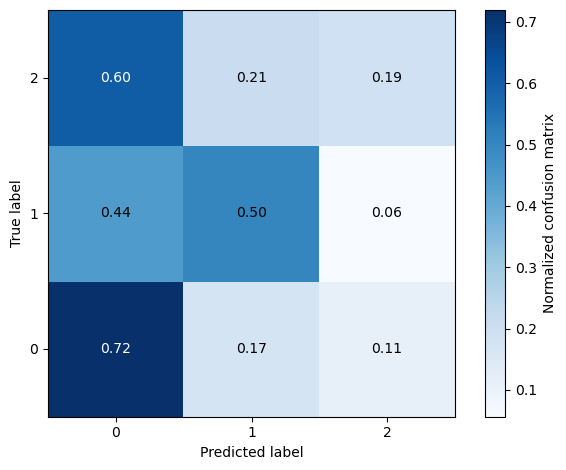

In [21]:
af.plot_confusion_matrix(swin_multi_all_labels, swin_multi_all_preds, classes=None, normalize=True, title=None, cmap=plt.cm.Blues)

In [73]:
# def get_strat_labels(dataset):
#     labels = []
#     for i in range(len(dataset)):
#         _, label = dataset[i]
#         label = tuple(label.cpu().numpy())
#         labels.append(label)
#     return labels

# def print_distribution_ratios(labels, subset_name=""):
#     counts = Counter(labels)
#     total = sum(counts.values())
#     print(f"{subset_name} distribution ratios:")
#     for label, count in counts.items():
#         ratio = count / total
#         print(f"  {label}: {ratio:.3f}")
#     print()

# orig_labels = get_strat_labels(multidata)
# train_labels = get_strat_labels(swin_multi_train_dataset)
# val_labels = get_strat_labels(swin_multi_val_dataset)
# test_labels = get_strat_labels(swin_multi_test_dataset)

# print_distribution_ratios(orig_labels, "Original")
# print_distribution_ratios(train_labels, "Train")
# print_distribution_ratios(val_labels, "Validation")
# print_distribution_ratios(test_labels, "Test")